In [74]:
# Use-case 1: Stock Market Price Prediction for Tesla Stock

# Begin by importing all necessary imports where we have decided to use a polynomial regression model to predict
# the stock price of Tesla as stock prices seldomly fluctuate linearly. 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [75]:
# First, we need to read in the csv data that we downloaded from the Tesla Yahoo pages.
url = "/Users/gisle/Documents/ARIMA-MODELLING/Tesla-Stock-Modelling/TSLA.csv"
# Create a data frame out of the raw data that we downloaded from Yahoo
df = pd.read_csv(url)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-24,205.820007,213.500000,198.589996,211.250000,211.250000,100446800
1,2022-10-25,210.100006,224.350006,210.000000,222.419998,222.419998,96507900
2,2022-10-26,219.399994,230.600006,218.199997,224.639999,224.639999,85012500
3,2022-10-27,229.770004,233.809998,222.850006,225.089996,225.089996,61638800
4,2022-10-28,225.399994,228.860001,216.350006,228.520004,228.520004,69152400
...,...,...,...,...,...,...,...
245,2023-10-16,250.050003,255.399994,248.479996,253.919998,253.919998,88917200
246,2023-10-17,250.100006,257.179993,247.080002,254.850006,254.850006,93562900
247,2023-10-18,252.699997,254.630005,242.080002,242.679993,242.679993,125147800
248,2023-10-19,225.949997,230.610001,216.779999,220.110001,220.110001,170772700


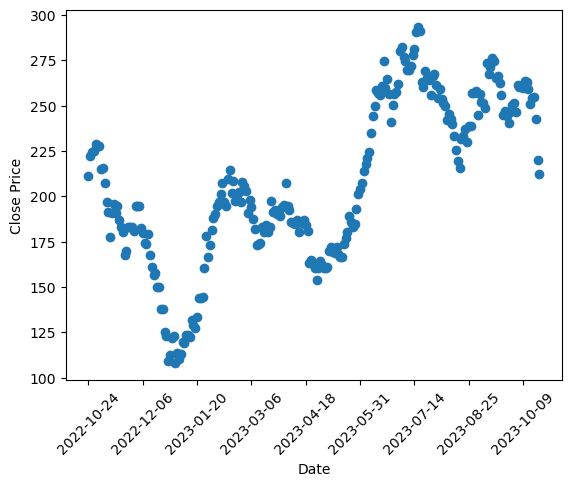

In [76]:
# Now we want to create a scatterplot where input is the date and the output is the closing price of the Tesla Stock
plt.scatter(x='Date', y='Close', data=df)
plt.xticks(df['Date'][::30], rotation=45)  # Label every 30th date, and rotate labels by 45 degrees for readability
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [77]:
# Now that we have visualized the stock price of this graph so far, let's apply the ARIMA model to the dataset.

# First we need to apply a stationary check to ensure that the time series are stationary

# Check for stationarity by performing the Dickey-Fuller test and we typically do this using the close price as the dependent variable
result = adfuller(df['Close'])
print('Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Calculate the critical values
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


Test Statistic: -1.718939
p-value: 0.421382
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [78]:
""" The test is not negative enough to strongly reject the null hypothesis of a unit root, i.e the significance of this is not enough to 
    rule out a unit root!
      
    The p value of 0.42 is very high, much higher than 0.01 or 0.05 so that there's not enough evidence to reject the null hypothesis of the presence
    of a unit root, so there's a fair chance that the series is non-stationary. Then we must transform the series to make it stationary! """

# Through trial and error, let's start off with differencing the data set
df['Close_diff'] = df['Close'].diff()
df = df.dropna()  # Drop rows with NaN values because otherwise we'd get errors with missing values

result1 = adfuller(df['Close_diff'])
print('Test Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])

Test Statistic: -5.935242
p-value: 0.000000


In [79]:
""" More promising results with the test statistic, but the 0 p value is very suspicious. 
    We'll add the log transformation to double check our calculations. """

# .loc acessor to state that we want to modify the original data frame
# Apply log transformation to the original 'Close' series
df.loc[:, 'Close_log'] = np.log(df['Close'])
# Calculate the first difference of the log-transformed series
df.loc[:, 'Close_log_diff'] = df['Close_log'].diff().dropna()

# Perform the ADF test on the first difference of the log-transformed series
result_log_diff = adfuller(df['Close_log_diff'].dropna())
print('Test Statistic: %f' % result_log_diff[0])
print('p-value: %f' % result_log_diff[1])

Test Statistic: -5.713192
p-value: 0.000001


C:\Users\gisle\AppData\Local\Temp\ipykernel_240220\2469617144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close_log'] = np.log(df['Close'])
C:\Users\gisle\AppData\Local\Temp\ipykernel_240220\2469617144.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close_log_diff'] = df['Close_log'].diff().dropna()


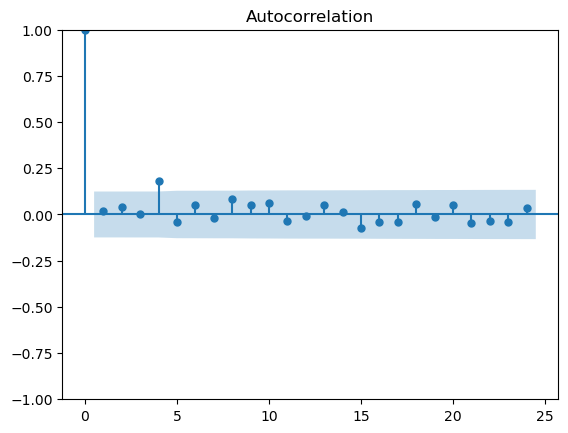

In [80]:
""" By both differencing and log transforming the dataset, we can see that the test statistic and the p value are similiar,
    thereby further strengthening statistical evidence that our time series can be considered stationary now. """

# Now that we have achieved a stationary dataset, we need to identify the model parameters p, d and q.

# We have already established d being the number of times the raw data observations are differenced, which was only done 1 time.

# We need to find p (AR order) 
# ACF plot for q with Close_diff as the differenced series
plot_acf(df['Close_diff'].dropna())
plt.show()

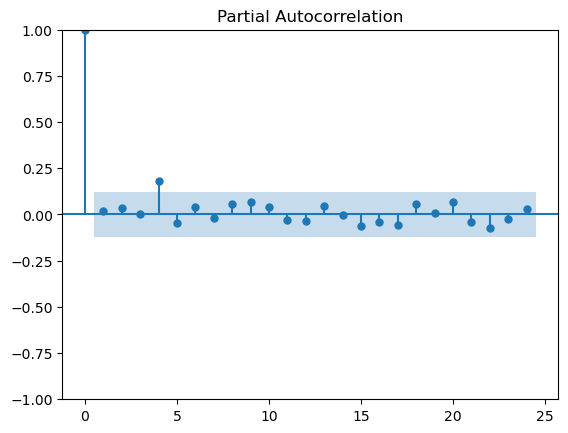

In [81]:
""" Here we can see that the first lag is significant as all subsequent lags seem to fall under the confidence intervals.
Given the plot, the first lag would be a good starting point!
We now have d = q = 1 so we only need p left. """

# PACF plot for p
plot_pacf(df['Close_diff'].dropna(), method='ywm')
plt.show()

In [82]:
""" Again the first lag is significantly higher than the others and we choose a p value of 1. """

p = 1
d = 1
q = 1

# Assuming p, d, q have been chosen
model = ARIMA(df['Close'], order=(p,d,q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  249
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -845.934
Date:                Mon, 19 Feb 2024   AIC                           1697.869
Time:                        19:30:15   BIC                           1708.409
Sample:                             0   HQIC                          1702.112
                                - 249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8908      0.157      5.687      0.000       0.584       1.198
ma.L1         -0.8443      0.185     -4.568      0.000      -1.207      -0.482
sigma2        53.7334      3.908     13.750      0.0

c:\Users\gisle\miniconda3\envs\dave3625\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gisle\miniconda3\envs\dave3625\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gisle\miniconda3\envs\dave3625\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


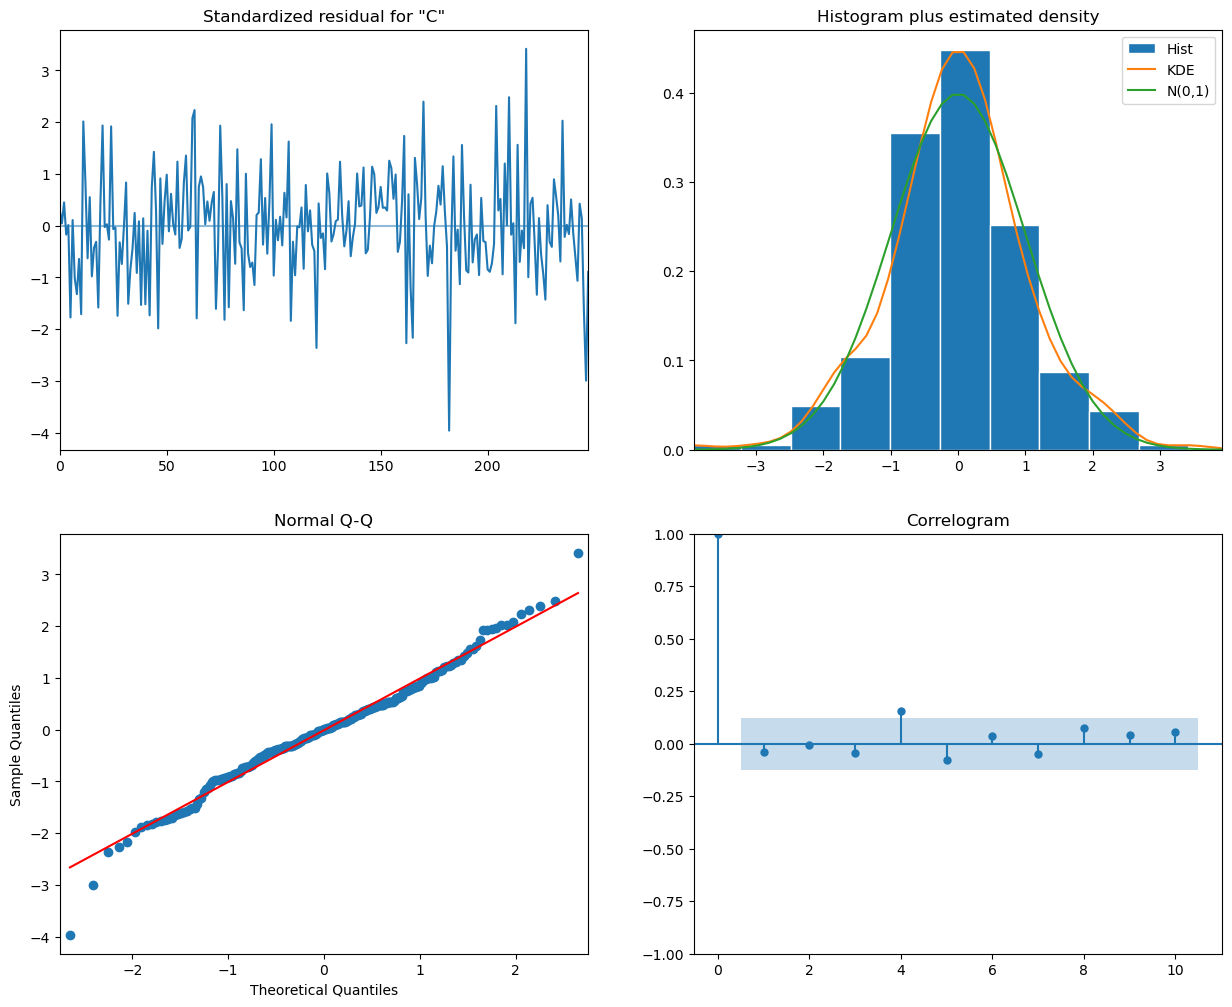

In [83]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

c:\Users\gisle\miniconda3\envs\dave3625\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


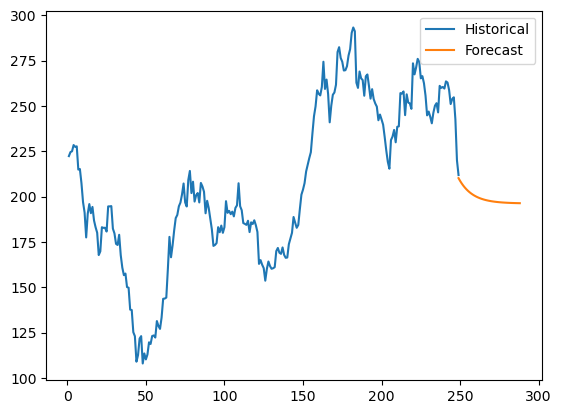

In [86]:

# Forecasting the next N steps ahead
forecast = model_fit.forecast(steps=40)

# Plot the forecast alongside historical data
plt.plot(df['Close'], label='Historical')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()
